In [1]:
# Make sure that you have all these libaries available to run the code successfully
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

### Obtain the daily return data from one stock 2006-2019

In [2]:
df = pd.read_csv("./atvi.csv")
df.head()
df.shape

(3271, 2)

### Plot the time series to see the return

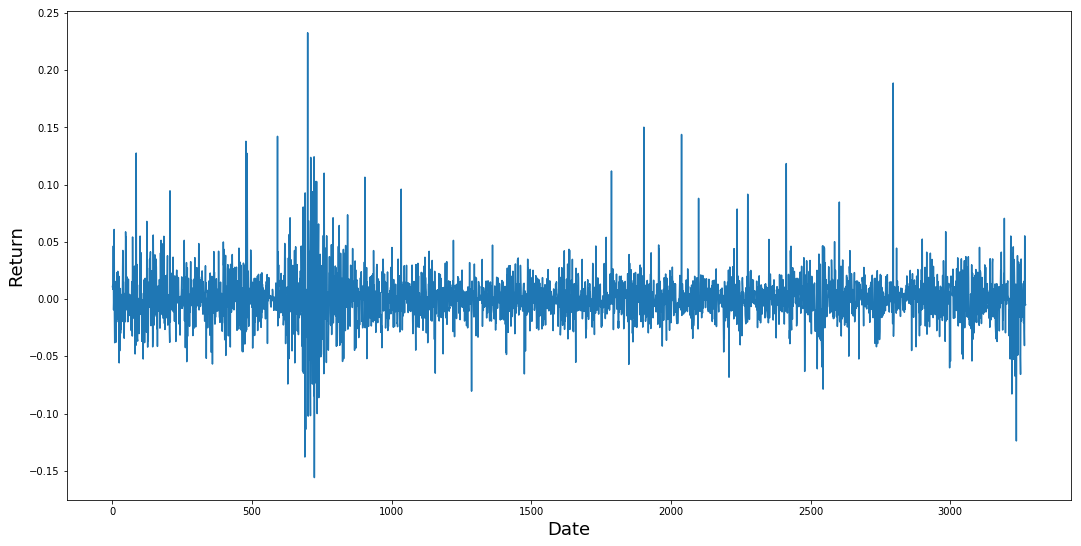

In [3]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),df['daily.returns'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Return',fontsize=18)
plt.show()

### Try to normalize the data and apply min max scalar

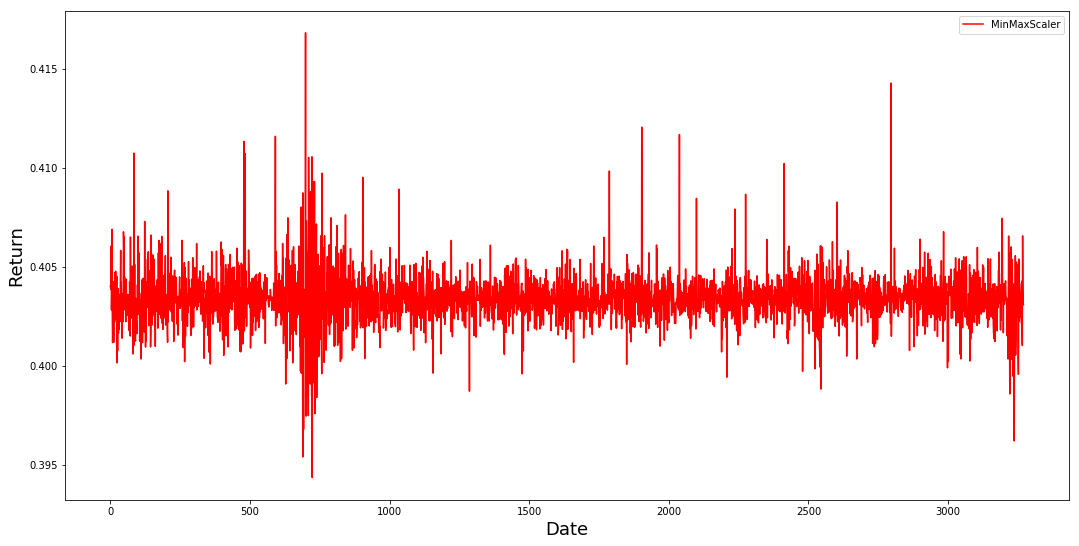

In [4]:
from sklearn.preprocessing import RobustScaler
raw = np.array(df['daily.returns'].values, dtype=np.float32)
normalized_return = (raw - np.mean(raw, axis=0))/np.std(raw,axis=0)
input_return=np.reshape(normalized_return, (-1, 1))
sc = MinMaxScaler()
sc.fit(input_return)
scaled_return = sc.transform(np.reshape(raw, (-1,1)))
scaled_return_2 = sc.fit_transform(input_return)
rc = RobustScaler()
rc_return = rc.fit_transform(np.reshape(raw, (-1,1)))
plt.figure(figsize = (18,9))
#plt.plot(rc_return, color="blue", label="RobustScaler")
#plt.plot(scaled_return_2, color="blue", lable="MinMaxScaler on Normalized data")
plt.plot(scaled_return, color = 'red', label = 'MinMaxScaler')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Return',fontsize=18)
plt.legend()
plt.show()

### First we will try to use LSTM model to prediction one step into the future. i.e. the return of the next day

* `TIME_STEP` -- number of steps used to predict the future price
* `BATCH_SIZE` -- Number of Batches used in one prediction
* `HIDDEN_UNITS` -- The number of units for the output
* `RNN_UNITS` -- The number of units in the LSTM network
* `LEARNING_RATE` -- The speed of the neural network learn dataset. i.e. larger --> faster --> cannot find global minima
* `EPOCH` -- number of cycle needed for training
* `SPLIT` -- how to split the traning set and testing set
* `DROPOUT` -- dropout rate of each layer of LSTM network

In [27]:
TIME_STEP_PRED=252
DAYS_REMOVE=20
TIME_STEP=TIME_STEP_PRED - DAYS_REMOVE
BATCH_SIZE=50
HIDDEN_UNITS=1
RNN_UNITS = 30
LEARNING_RATE=0.0001
EPOCH=150
SPLIT=0.8
DROPOUT=0.8

### Generate data_sets

Here we used robust scaling, which is just normalized the return data, which gave a better performance. Min_Max_scaled data has also been tested but not that good. __Idea worth trying:__
* use 5-day mean return to reduce the peak values, but the data size will decrease
* use bootstrapping to generate more data, but may not reflect real return

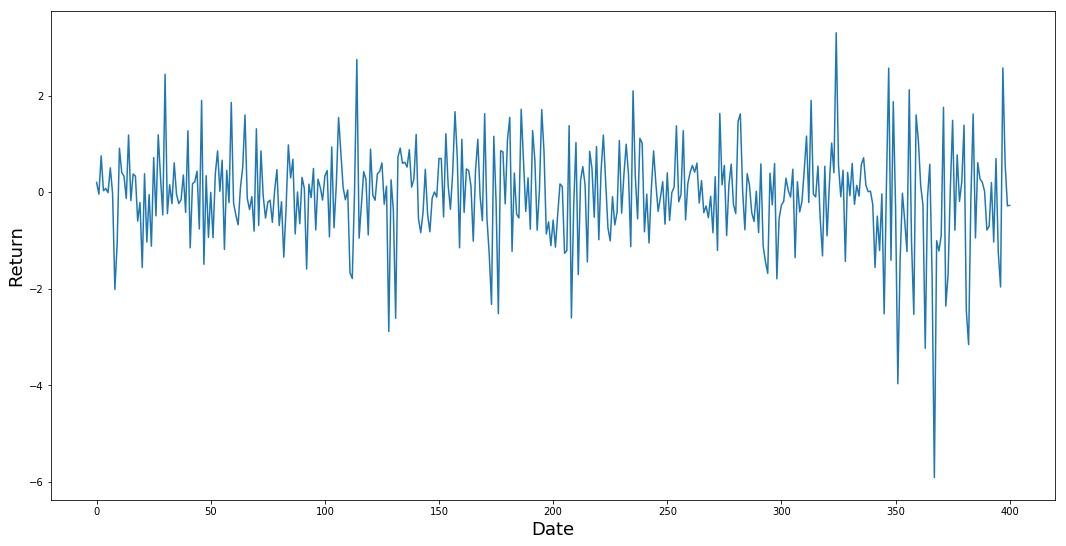

(2365, 232, 1)
(401, 232, 1)
(2365, 1)
(401, 1)


In [28]:
#data_set = df['daily.returns'].values
data_set = rc_return
def window_data(window_size, data_set, remove_size):
    X = []
    Y = []
    for i in range(window_size, len(data_set)):
#         X.append(data_set[i-window_size:i])
#         Y.append(data_set[i])
# taking out the last month's data, one month reversion thoery
        X.append(data_set[i-window_size:i-remove_size])
        Y.append(data_set[i])
    return np.array(X, dtype=np.float32),np.array(Y, dtype=np.float32)
    
split_index = round(len(data_set)*SPLIT)
# X_train, Y_train = window_data(TIME_STEP, data_set[:split_index])
# X_test, Y_test = window_data(TIME_STEP, data_set[split_index+1:])
X_train, Y_train = window_data(TIME_STEP_PRED, data_set[:split_index], DAYS_REMOVE)
X_test, Y_test = window_data(TIME_STEP_PRED, data_set[split_index+1:], DAYS_REMOVE)

X_train = np.reshape(X_train, (-1, TIME_STEP, 1))
X_test = np.reshape(X_test, (-1, TIME_STEP, 1))
Y_train = np.reshape(Y_train,(-1, 1))
Y_test = np.reshape(Y_test,(-1,1))


plt.figure(figsize = (18,9))
plt.plot(range(len(Y_test)),Y_test)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Return',fontsize=18)
plt.show()

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

### Build LSTM network
1. input and out has the dimension (?, `TIME_STEP`, 1) and (?, 1) required by the `BasicLSTMCell`
2. constructed a LSTM from `BasciLSTMCell`
3. constructed a network from `Dynamic_rnn` __May try calculating RNN by our selfs to customize every layer__
4. Loss function using Mean square error __May try using different losss__
5. Used Adam Optimizer

#### update: find adding a regression layer infront and in the end get a better result

In [29]:
graph = tf.Graph()
with graph.as_default():
    
    inputs = tf.placeholder(dtype=tf.float32, shape=(None, TIME_STEP, 1), name="input_placeholder")
    pred = tf.placeholder(dtype=tf.float32, shape=(None, 1), name="prediction_placeholder")
    
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=HIDDEN_UNITS)
    
    init_state=lstm_cell.zero_state(batch_size=BATCH_SIZE, dtype=tf.float32)
    
    outputs, states = tf.nn.dynamic_rnn(cell=lstm_cell, inputs=inputs, initial_state=init_state, dtype=tf.float32)
    print(outputs.shape)
    
    h=outputs[:,-1,:]
    print(h.shape)
    
    mse=tf.losses.mean_squared_error(labels=pred,predictions=h)
    print(mse.shape)

    optimizer=tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss=mse)
    
    init=tf.global_variables_initializer()
    

(50, 232, 1)
(50, 1)
()


### This is used as preferred model

In [30]:
graph_dropout = tf.Graph()
with graph_dropout.as_default():
    

    inputs = tf.placeholder(dtype=tf.float32, shape=(None, TIME_STEP, 1), name="input_placeholder")
    pred = tf.placeholder(dtype=tf.float32, shape=(None, 1), name="prediction_placeholder")
    
    weights={
        'in':tf.Variable(tf.random_normal(shape=(1, RNN_UNITS))),
        'out':tf.Variable(tf.random_normal(shape=(RNN_UNITS, 1)))
    }
    
    biases={
        'in':tf.Variable(tf.constant(0.1, shape=(RNN_UNITS,))),
        'out':tf.Variable(tf.constant(0.1, shape=(1,)))
    }
    
    reshaped_inputs = tf.reshape(inputs, [-1, 1])
    print(reshaped_inputs)
    input_rnn = tf.matmul(reshaped_inputs, weights['in']) + biases['in']
    input_rnn = tf.reshape(input_rnn, [-1, TIME_STEP, RNN_UNITS])
    print(input_rnn.shape)
    
    lstm_cell1 = tf.contrib.rnn.BasicLSTMCell(RNN_UNITS)
    lstm_cell2 = tf.contrib.rnn.BasicLSTMCell(RNN_UNITS)
    drop_cell = [tf.contrib.rnn.DropoutWrapper(lstm, input_keep_prob=1, output_keep_prob=1-DROPOUT, state_keep_prob=1-DROPOUT)
                for lstm in[lstm_cell1, lstm_cell2]]
    cell=tf.contrib.rnn.MultiRNNCell(cells=drop_cell)
    
    init_state=cell.zero_state(batch_size=BATCH_SIZE, dtype=tf.float32)
    print(init_state)

    with tf.variable_scope('scope', reuse=tf.AUTO_REUSE):
        output_rnn, states = tf.nn.dynamic_rnn(cell=cell, inputs=input_rnn, initial_state=init_state, dtype=tf.float32)
    print(output_rnn)
    outputs = output_rnn[:,-1,:]
    print(outputs.shape)
    h = tf.matmul(outputs, weights['out']) + biases['out']
    print(h.shape)
    
    mse=tf.losses.mean_squared_error(labels=pred,predictions=h)
    print(mse.shape)

    optimizer=tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss=mse)
    
    init=tf.global_variables_initializer()

Tensor("Reshape:0", shape=(?, 1), dtype=float32)
(?, 232, 30)
(LSTMStateTuple(c=<tf.Tensor 'MultiRNNCellZeroState/DropoutWrapperZeroState/BasicLSTMCellZeroState/zeros:0' shape=(50, 30) dtype=float32>, h=<tf.Tensor 'MultiRNNCellZeroState/DropoutWrapperZeroState/BasicLSTMCellZeroState/zeros_1:0' shape=(50, 30) dtype=float32>), LSTMStateTuple(c=<tf.Tensor 'MultiRNNCellZeroState/DropoutWrapperZeroState_1/BasicLSTMCellZeroState/zeros:0' shape=(50, 30) dtype=float32>, h=<tf.Tensor 'MultiRNNCellZeroState/DropoutWrapperZeroState_1/BasicLSTMCellZeroState/zeros_1:0' shape=(50, 30) dtype=float32>))
Tensor("scope/rnn/transpose_1:0", shape=(50, 232, 30), dtype=float32)
(50, 30)
(50, 1)
()


### Try to reduce overfitting by add two more layer and may dropout layer

In [35]:
graph_add = tf.Graph()
with graph_add.as_default():
    

    inputs = tf.placeholder(dtype=tf.float32, shape=(None, TIME_STEP, 1), name="input_placeholder")
    pred = tf.placeholder(dtype=tf.float32, shape=(None, 1), name="prediction_placeholder")
    
    weights={
        'in':tf.Variable(tf.random_normal(shape=(1, RNN_UNITS))),
        'out':tf.Variable(tf.random_normal(shape=(RNN_UNITS, 1)))
    }
    
    biases={
        'in':tf.Variable(tf.constant(0.1, shape=(RNN_UNITS,))),
        'out':tf.Variable(tf.constant(0.1, shape=(1,)))
    }
    
    reshaped_inputs = tf.reshape(inputs, [-1, 1])
    print(reshaped_inputs)
    input_rnn = tf.matmul(reshaped_inputs, weights['in']) + biases['in']
    input_rnn = tf.reshape(input_rnn, [-1, TIME_STEP, RNN_UNITS])
    print(input_rnn.shape)
    
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(RNN_UNITS)
    
    init_state=lstm_cell.zero_state(batch_size=BATCH_SIZE, dtype=tf.float32)
    print(init_state)

    with tf.variable_scope('scope', reuse=tf.AUTO_REUSE):
        output_rnn, states = tf.nn.dynamic_rnn(cell=lstm_cell, inputs=input_rnn, initial_state=init_state, dtype=tf.float32)
    print(output_rnn)
    outputs = output_rnn[:,-1,:]
    print(outputs.shape)
    h = tf.matmul(outputs, weights['out']) + biases['out']
    print(h.shape)
    
    mse=tf.losses.mean_squared_error(labels=pred,predictions=h)
    print(mse.shape)

    optimizer=tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss=mse)
    
    init=tf.global_variables_initializer()

Tensor("Reshape:0", shape=(?, 1), dtype=float32)
(?, 232, 30)
LSTMStateTuple(c=<tf.Tensor 'BasicLSTMCellZeroState/zeros:0' shape=(50, 30) dtype=float32>, h=<tf.Tensor 'BasicLSTMCellZeroState/zeros_1:0' shape=(50, 30) dtype=float32>)
Tensor("scope/rnn/transpose_1:0", shape=(50, 232, 30), dtype=float32)
(50, 30)
(50, 1)
()


### Run model training and testing with corss validation

epoch: 10/150
average training loss:  1.1473327577114105
average testing loss:  1.247331328690052
epoch: 20/150
average training loss:  1.1369207314354308
average testing loss:  1.248606115579605
epoch: 30/150
average training loss:  1.1295885903404115
average testing loss:  1.2511061877012253
epoch: 40/150
average training loss:  1.1237563278446807
average testing loss:  1.2541619166731834
epoch: 50/150
average training loss:  1.119293674826622
average testing loss:  1.257526583969593
epoch: 60/150
average training loss:  1.1152873023393306
average testing loss:  1.2607146352529526
epoch: 70/150
average training loss:  1.1113683131146939
average testing loss:  1.2638860046863556
epoch: 80/150
average training loss:  1.1073575092757002
average testing loss:  1.2670749872922897
epoch: 90/150
average training loss:  1.103173665226774
average testing loss:  1.2703099697828293
epoch: 100/150
average training loss:  1.0987611076933272
average testing loss:  1.273629367351532
epoch: 110/150


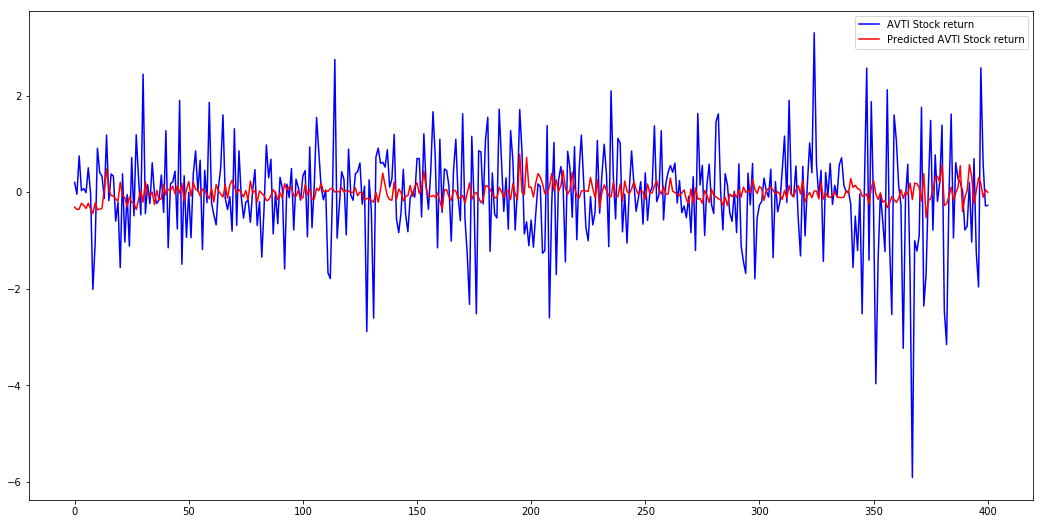

In [38]:
#with tf.Session(graph=graph) as sess:
with tf.Session(graph=graph_add) as sess:
#with tf.Session(graph=graph_dropout) as sess:
    sess.run(init)
    for epoch in range(1, EPOCH+1):
        results = np.zeros(shape=(len(Y_test),1))
        train_losses=[]
        test_losses=[]
        for j in range(len(Y_train)//BATCH_SIZE):
            _, train_loss=sess.run(
                            fetches=(optimizer, mse),
                            feed_dict={
                                inputs:X_train[j*BATCH_SIZE:(j+1)*BATCH_SIZE],
                                pred:Y_train[j*BATCH_SIZE:(j+1)*BATCH_SIZE]
                            })
            train_losses.append(train_loss)

        
        for j in range(len(Y_test)//BATCH_SIZE):
            result, test_loss=sess.run(
                                fetches=(h,mse), 
                                feed_dict={
                                    inputs:X_test[j*BATCH_SIZE:(j+1)*BATCH_SIZE],
                                    pred:Y_train[j*BATCH_SIZE:(j+1)*BATCH_SIZE]
                                })
            results[j*BATCH_SIZE:(j+1)*BATCH_SIZE] = result
            test_losses.append(test_loss)
        
        if epoch % 10 == 0:
            print("epoch: {}/{}".format(epoch, EPOCH))
            print("average training loss: ", sum(train_losses)/len(train_losses))
            print("average testing loss: ", sum(test_losses)/len(test_losses))
    plt.figure(figsize = (18,9))
    plt.plot(Y_test, color = 'blue', label = 'AVTI Stock return')
    plt.plot(results, color = 'red', label = 'Predicted AVTI Stock return')
    plt.legend()
    plt.show()

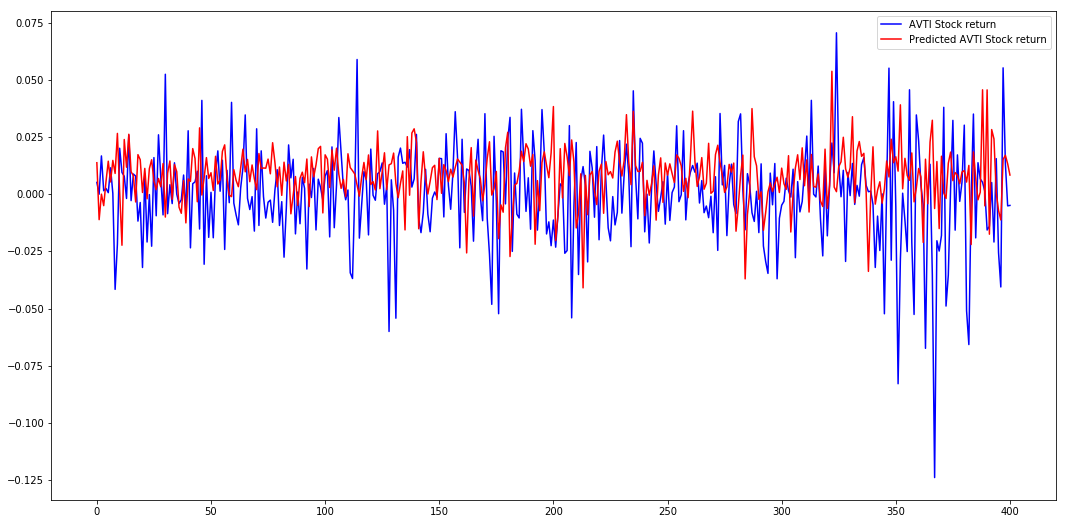

In [34]:
    plt.figure(figsize = (18,9))
    plt.plot(rc.inverse_transform(Y_test), color = 'blue', label = 'AVTI Stock return')
    plt.plot(rc.inverse_transform(results)*10, color = 'red', label = 'Predicted AVTI Stock return')
    plt.legend()
    plt.show()

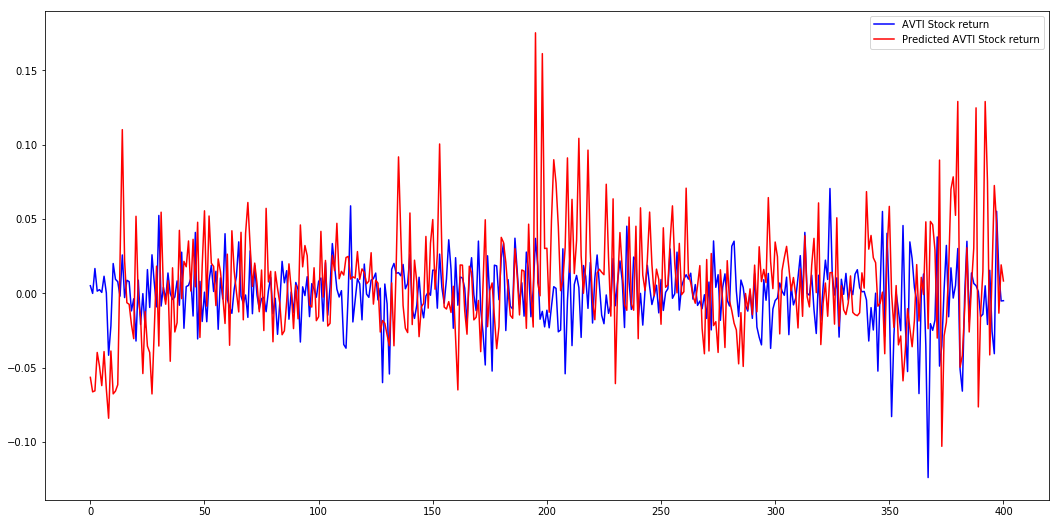

In [39]:
    plt.figure(figsize = (18,9))
    plt.plot(rc.inverse_transform(Y_test), color = 'blue', label = 'AVTI Stock return')
    plt.plot(rc.inverse_transform(results)*10, color = 'red', label = 'Predicted AVTI Stock return')
    plt.legend()
    plt.show()

In [32]:
results

array([[ 2.55671777e-02],
       [-9.23300236e-02],
       [-3.95429172e-02],
       [-6.33291304e-02],
       [-1.36604793e-02],
       [ 2.86917631e-02],
       [-1.42487697e-02],
       [ 3.03156804e-02],
       [ 3.32559831e-03],
       [ 8.62290785e-02],
       [-3.58298980e-02],
       [-1.45317838e-01],
       [ 7.35917985e-02],
       [ 1.62058137e-02],
       [ 8.44863653e-02],
       [ 6.94712065e-03],
       [-1.45126320e-03],
       [-5.57031296e-02],
       [ 4.22610193e-02],
       [ 3.18160169e-02],
       [-3.60763781e-02],
       [ 1.37858968e-02],
       [-4.91621532e-02],
       [ 1.32611766e-02],
       [ 3.16827931e-02],
       [-1.24230608e-02],
       [-3.01944725e-02],
       [-7.06070289e-03],
       [-2.42510885e-02],
       [ 2.37355158e-02],
       [-8.69406313e-02],
       [ 4.10293043e-03],
       [ 2.91635804e-02],
       [-5.03102280e-02],
       [ 2.17573531e-02],
       [ 7.01925904e-03],
       [-6.66072220e-02],
       [-7.91526288e-02],
       [-1.1

In [33]:
Y_test

array([[ 2.04147965e-01],
       [-3.95900495e-02],
       [ 7.52534449e-01],
       [ 3.19599845e-02],
       [ 7.94763714e-02],
       [-7.91721605e-03],
       [ 5.06386638e-01],
       [-2.39450131e-02],
       [-2.01021314e+00],
       [-1.07585001e+00],
       [ 9.11411464e-01],
       [ 4.10190374e-01],
       [ 3.33050042e-01],
       [-1.28004819e-01],
       [ 1.18441653e+00],
       [-1.73034251e-01],
       [ 3.77621025e-01],
       [ 3.34962606e-01],
       [-5.97010374e-01],
       [-2.11940110e-01],
       [-1.55710769e+00],
       [ 3.82812500e-01],
       [-1.02989924e+00],
       [-4.78149801e-02],
       [-1.11702967e+00],
       [ 7.17872143e-01],
       [-4.86911297e-01],
       [ 1.18973005e+00],
       [ 3.02754223e-01],
       [-4.68495250e-01],
       [ 2.44304347e+00],
       [-4.43094492e-01],
       [ 1.56069845e-01],
       [-2.34444767e-01],
       [ 6.10002398e-01],
       [-3.95900495e-02],
       [-2.32602030e-01],
       [-1.55872777e-01],
       [ 3.5

## Try to construct m-dimensional return prediction

In [67]:
TIME_STEP_PRED=252
DAYS_REMOVE=0
TIME_STEP=TIME_STEP_PRED - DAYS_REMOVE
BATCH_SIZE=50
HIDDEN_UNITS=2
RNN_UNITS = 30
LEARNING_RATE=0.0001
EPOCH=150
SPLIT=0.8
DROPOUT=0.8
D=2

In [64]:
data_set = df.iloc[:,:].values
def window_data(window_size, data_set):
    X = []
    Y = []
    for i in range(window_size, len(data_set)):
#         X.append(data_set[i-window_size:i])
#         Y.append(data_set[i])
# taking out the last month's data, one month reversion thoery
        X.append(data_set[i-window_size:i,:])
        Y.append(data_set[i,:])
    return np.array(X, dtype=np.float32),np.array(Y, dtype=np.float32)
    
split_index = round(len(data_set)*SPLIT)
# X_train, Y_train = window_data(TIME_STEP, data_set[:split_index])
# X_test, Y_test = window_data(TIME_STEP, data_set[split_index+1:])
X_train, Y_train = window_data(TIME_STEP_PRED, data_set[:split_index])
X_test, Y_test = window_data(TIME_STEP_PRED, data_set[split_index+1:])

X_train = np.reshape(X_train, (-1, TIME_STEP, D))
X_test = np.reshape(X_test, (-1, TIME_STEP, D))
Y_train = np.reshape(Y_train,(-1, D))
Y_test = np.reshape(Y_test,(-1,D))

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(2365, 252, 2)
(401, 252, 2)
(2365, 2)
(401, 2)


In [68]:
graph = tf.Graph()
with graph.as_default():
    
    inputs = tf.placeholder(dtype=tf.float32, shape=(None, TIME_STEP, D), name="input_placeholder")
    pred = tf.placeholder(dtype=tf.float32, shape=(None, D), name="prediction_placeholder")
    
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=HIDDEN_UNITS)
    
    init_state=lstm_cell.zero_state(batch_size=BATCH_SIZE, dtype=tf.float32)
    
    outputs, states = tf.nn.dynamic_rnn(cell=lstm_cell, inputs=inputs, initial_state=init_state, dtype=tf.float32)
    print(outputs.shape)
    
    h=outputs[:,-1,:]
    print(h.shape)
    
    mse=tf.losses.mean_squared_error(labels=pred,predictions=h)
    print(mse.shape)

    optimizer=tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss=mse)
    
    init=tf.global_variables_initializer()

(50, 252, 2)
(50, 2)
()


In [70]:
with tf.Session(graph=graph) as sess:
#with tf.Session(graph=graph_add) as sess:
#with tf.Session(graph=graph_dropout) as sess:
    sess.run(init)
    for epoch in range(1, EPOCH+1):
        results = np.zeros(shape=(len(Y_test),D))
        train_losses=[]
        test_losses=[]
        for j in range(len(Y_train)//BATCH_SIZE):
            _, train_loss=sess.run(
                            fetches=(optimizer, mse),
                            feed_dict={
                                inputs:X_train[j*BATCH_SIZE:(j+1)*BATCH_SIZE],
                                pred:Y_train[j*BATCH_SIZE:(j+1)*BATCH_SIZE]
                            })
            train_losses.append(train_loss)

        
        for j in range(len(Y_test)//BATCH_SIZE):
            result, test_loss=sess.run(
                                fetches=(h,mse), 
                                feed_dict={
                                    inputs:X_test[j*BATCH_SIZE:(j+1)*BATCH_SIZE],
                                    pred:Y_train[j*BATCH_SIZE:(j+1)*BATCH_SIZE]
                                })
            results[j*BATCH_SIZE:(j+1)*BATCH_SIZE] = result
            test_losses.append(test_loss)
        
        if epoch % 10 == 0:
            print("epoch: {}/{}".format(epoch, EPOCH))
            print("average training loss: ", sum(train_losses)/len(train_losses))
            print("average testing loss: ", sum(test_losses)/len(test_losses))


epoch: 10/150
average training loss:  1250410.2094414893
average testing loss:  109497.748046875
epoch: 20/150
average training loss:  1250410.2094414893
average testing loss:  109497.748046875
epoch: 30/150
average training loss:  1250410.2094414893
average testing loss:  109497.748046875
epoch: 40/150
average training loss:  1250410.2094414893
average testing loss:  109497.748046875
epoch: 50/150
average training loss:  1250410.2094414893
average testing loss:  109497.748046875
epoch: 60/150
average training loss:  1250410.2094414893
average testing loss:  109497.748046875
epoch: 70/150
average training loss:  1250410.2094414893
average testing loss:  109497.748046875
epoch: 80/150
average training loss:  1250410.2094414893
average testing loss:  109497.748046875
epoch: 90/150
average training loss:  1250410.2094414893
average testing loss:  109497.748046875
epoch: 100/150
average training loss:  1250410.2094414893
average testing loss:  109497.748046875
epoch: 110/150
average traini

In [102]:
with open("./weights.txt", "r") as f:
    weights = np.loadtxt(f, dtype=np.float32, delimiter=",")

weights.shape


(1227, 167)

In [84]:
matrix.shape

(1227, 103)

In [99]:
import re
names = ""
with open("./names.txt", "r") as f:
    for lines in f.readlines():
        raw = lines.strip()
        for name in raw.split()[1:]:
            names += "," + name
print(names)

,"AAL","AAPL","ADBE","ADI","ADP","ADSK","AKAM","ALGN","ALTR","ALXN","AMAT","AMD","AMGN","AMZN","ASML","ATVI","AVGO","BBBY","BIDU","BIIB","BKNG","BMRN","CDNS","CELG","CERN","CHKP","CHRW","CHTR","CMCSA","COST","CSCO","CSX","CTAS","CTRP","CTSH","CTXS","DISCA","DISCK","DISH","DLTR","DTV","EA","EBAY","ENDP","EQIX","EXPD","EXPE","FAST","FB","FISV","FOX","FOXA","GILD","GOOG","GOOGL","GRMN","HAS","HOLX","HSIC","IDXX","ILMN","INCY","INTC","INTU","ISRG","JBHT","JD","KHC","KLAC","LBTYA","LBTYK","LILA","LILAK","LRCX","LULU","MAR","MAT","MCHP","MDLZ","MELI","MNST","MSFT","MU","MXIM","MYL","NCLH","NFLX","NTAP","NTES","NVDA","NXPI","ORLY","PAYX","PCAR","PEP","PYPL","QCOM","QRTEA","REGN","ROST","SBAC","SBUX","SIRI","SNPS","SRCL","STX","SWKS","SYMC","TMUS","TRIP","TSCO","TSLA","TTWO","TXN","UAL","ULTA","VIAB","VOD","VRSK","VRTX","WBA","WDAY","WDC","WLTW","WYNN","XEL","XLNX","XRAY","VRSN","VIA","BATRA","BATRK","FFIV","LSXMB","PRGO","ORCL","BMC","DELL","GOLD","FOSL","NUAN","SHLDQ","FSLR","TEVA","INFY","F